In [42]:
%load_ext autoreload
%autoreload 2

from ocean_navigation_simulator.generative_error_model.generative_model_metrics import rmse_over_time_xr, rmse_over_time, vector_correlation_over_time_xr, vector_correlation_over_time
from ocean_navigation_simulator.generative_error_model.GAN.data_postprocessing import ConvertToError, get_sparse_from_nc

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import ensverif as e


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compute RMSE

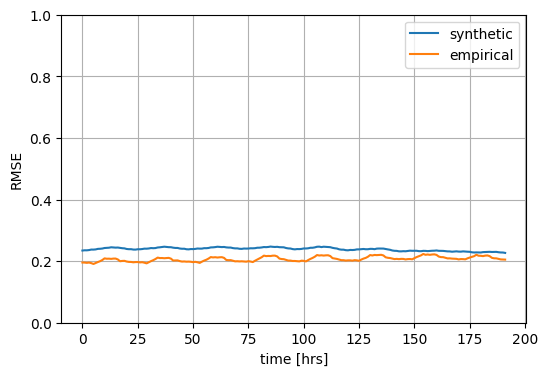

In [10]:
# # write nc files from raw GAN predictions
# predictions_dir = "../../../data/drifter_data/GAN_samples/2022-11-28_20:38:37"
# ground_truth_dir = "../../../data/drifter_data/buoy_preprocessed_test/area1"
# eval = ConvertToError(predictions_dir, ground_truth_dir)
# error_root = "../../../data/drifter_data/GAN_nc/errors"
# eval.get_individual_as_nc(error_root, type="error")

# load synthetic error nc files
error_root = "../../../data/drifter_data/GAN_nc/errors"
files = os.listdir(error_root)
rmse = []
for file in files:
    data = xr.open_dataset(os.path.join(error_root, file), engine="netcdf4")
    rmse.append(rmse_over_time_xr(data, variables=("water_u", "water_v")))
rmse = np.array(rmse).mean(axis=0)

# empirical
error_data_root = "../../../data/drifter_data/dataset_forecast_error/area1_edited"
files = sorted(os.listdir(error_data_root))
rmse_data = []
for file in files[:50]:
    data = pd.read_csv(os.path.join(error_data_root, file))
    rmse_data.append(rmse_over_time(data, variables=("u_error", "v_error"))["rmse"])
# take average for each hour
rmse_data = np.array(rmse_data).mean(axis=0)[:192]

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(rmse)), rmse, label="synthetic")
plt.plot(range(len(rmse_data)), rmse_data, label="empirical")
plt.ylim([0, 1.0])
plt.ylabel("RMSE")
plt.xlabel("time [hrs]")
plt.grid()
plt.legend()

# Compute Vector Correlation

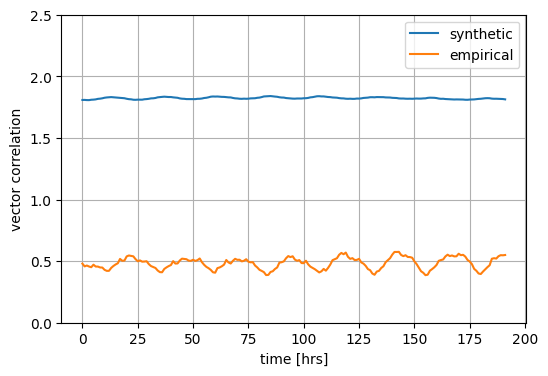

In [11]:
# predicted currents vs forecast

# # write nc file for forecasts from raw GAN output
# eval = ConvertToError(predictions_dir, ground_truth_dir)
# forecast_root = "../../../data/drifter_data/GAN_nc/forecasts"
# eval.get_individual_as_nc(forecast_root, type="current")

# load synthetic error nc files
forecast_root = "../../../data/drifter_data/GAN_nc/forecasts"
error_files = sorted(os.listdir(error_root))
forecast_files = sorted(os.listdir(forecast_root))

vec_corr = []
for error_file, forecast_file in zip(error_files, forecast_files):
    error_data = xr.open_dataset(os.path.join(error_root, error_file))
    forecast_data = xr.open_dataset(os.path.join(forecast_root, forecast_file))
    temp_vec_corr = vector_correlation_over_time_xr(error_data, forecast_data)
    vec_corr.append(temp_vec_corr)
vec_corr = np.array(vec_corr).mean(axis=0)

# empirical
# use forecast error + forecast or alternatively buoy data directly
# use forecast+error vs forecast
forecast_error_root = "../../../data/drifter_data/dataset_forecast_error/area1_edited"
error_files = sorted(os.listdir(forecast_error_root))[:20]
vec_corr_emp = []
for file in error_files:
    data = pd.read_csv(os.path.join(forecast_error_root, file))
    vec_corr_emp.append(vector_correlation_over_time(data))
vec_corr_emp = np.array(vec_corr_emp).mean(axis=0)[:192]

fig = plt.figure(figsize=(6,4))
plt.plot(range(len(vec_corr)), vec_corr, label="synthetic")
plt.plot(range(len(vec_corr_emp)), vec_corr_emp, label="empirical")
plt.ylim([0, 2.5])
plt.xlabel("time [hrs]")
plt.ylabel("vector correlation")
plt.grid()
plt.legend()

# Compute Variogram

In [9]:
# # compute contiguous volume of error
# predictions_dir = "../../../data/drifter_data/GAN_samples/2022-11-28_20:38:37"
# ground_truth_dir = "../../../data/drifter_data/buoy_preprocessed_test/area1"
# eval = ConvertToError(predictions_dir, ground_truth_dir)
# ds = eval.get_max_volume_as_nc()
# output_path = "../../../data/drifter_data/GAN_nc/sample_volume.nc"
# ds.to_netcdf(output_path)

output_path = "../../../data/drifter_data/GAN_nc/sample_volume.nc"
data = get_sparse_from_nc(output_path)
data

,lon,lat,time,u_error,v_error
0,-131.416667,28.333333,2022-10-12 15:30:00,0.000000,0.000000
1,-135.916667,17.5,2022-10-05 09:30:00,-0.255768,0.120319
2,-130.25,21.166667,2022-09-29 17:30:00,-0.240038,-0.106311
3,-139.75,22.083333,2022-10-03 12:30:00,0.067296,-0.048509
4,-127.833333,21.75,2022-09-23 16:30:00,-0.136837,-0.171950
...,...,...,...,...,...
29995,-137.5,16.833333,2022-10-12 18:30:00,0.000000,0.000000
29996,-143.75,25.5,2022-09-23 06:30:00,0.125187,0.168573
29997,-131.75,19.5,2022-09-22 07:30:00,-0.104185,0.121737
29998,-133.166667,15.583333,2022-10-09 19:30:00,0.000000,0.000000


In [10]:
from ocean_navigation_simulator.generative_error_model.variogram.Variogram import Variogram
from ocean_navigation_simulator.generative_error_model.variogram.VisualizeVariogram import VisualizeVariogram

# compute variogram
v = Variogram(data)
v.detrend()
bins, bins_count = v.build_variogram((5, 1), num_workers=2, chunk_size=int(1e6), cross_buoy_pairs_only=False, is_3d=False)

array([<AxesSubplot:xlabel='space_lag [km]', ylabel='Semivariance'>,
       <AxesSubplot:xlabel='t_lag [hrs]', ylabel='Semivariance'>],
      dtype=object)

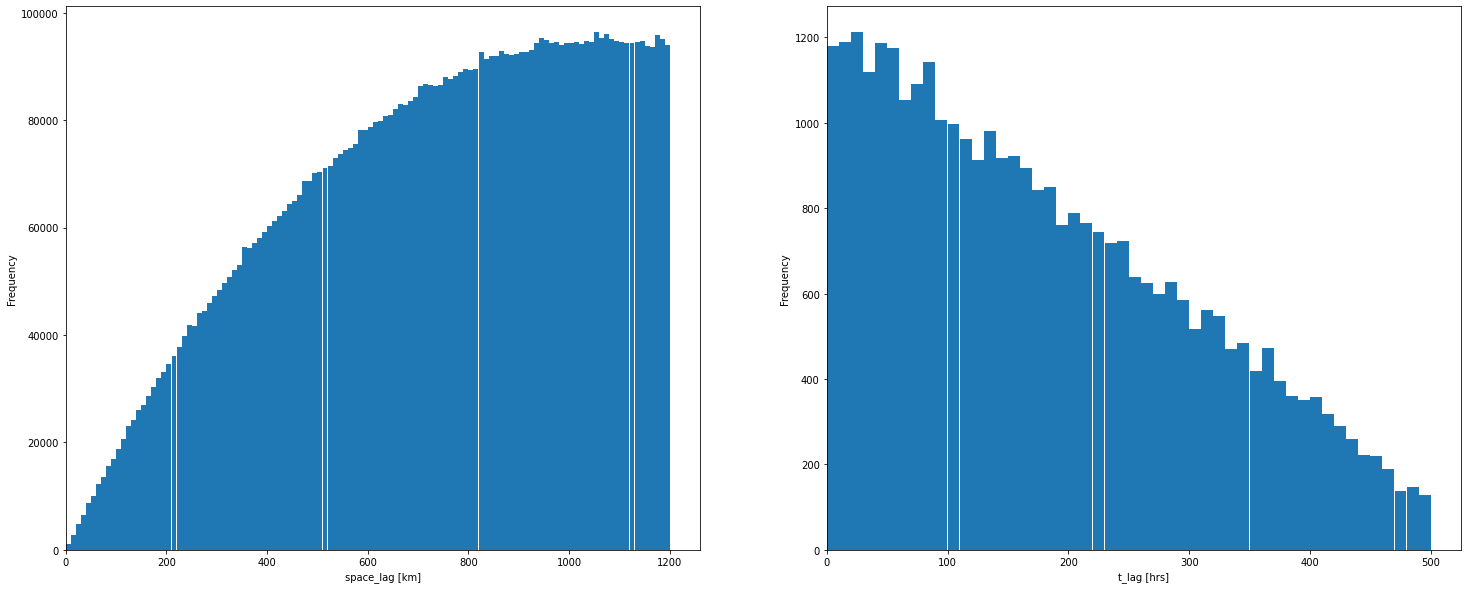

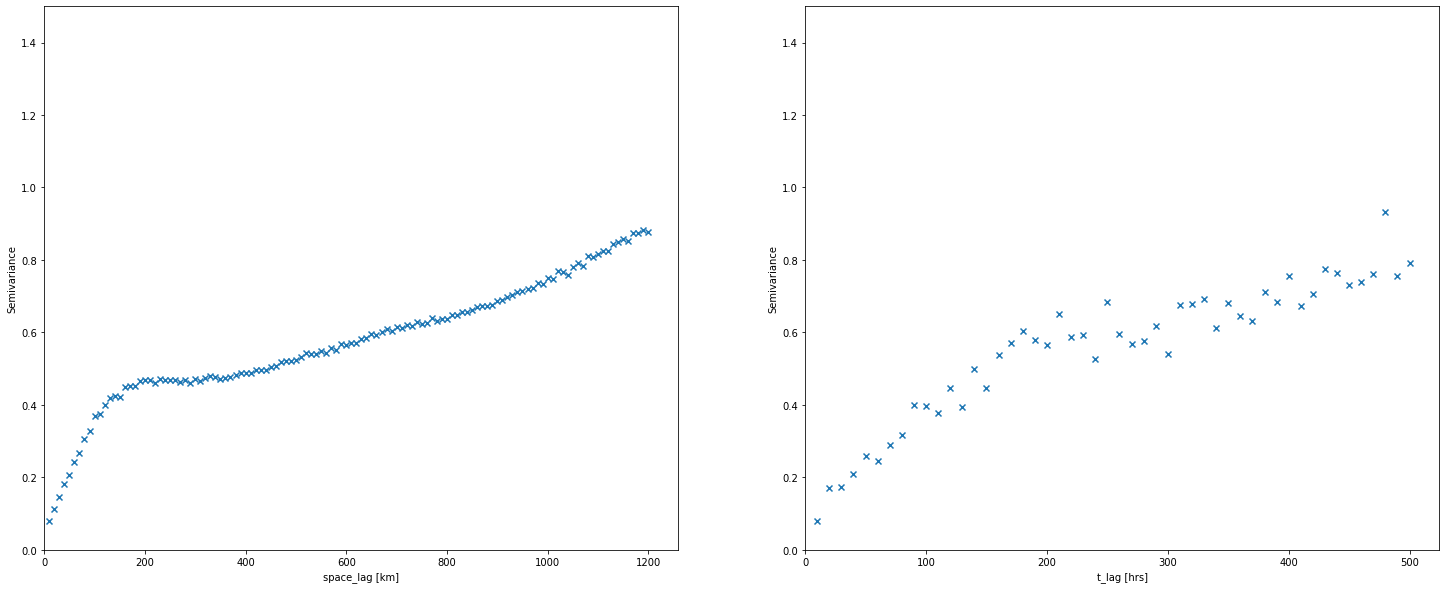

In [12]:
vvis = VisualizeVariogram(variogram=v)
vvis.decrease_variogram_res((10, 10))
view_range = [1200, 500]
vvis.plot_histograms(view_range=view_range)
vvis.plot_variograms(error_variable="u", view_range=view_range)

array([<AxesSubplot:xlabel='space_lag [km]', ylabel='Semivariance'>,
       <AxesSubplot:xlabel='t_lag [hrs]', ylabel='Semivariance'>],
      dtype=object)

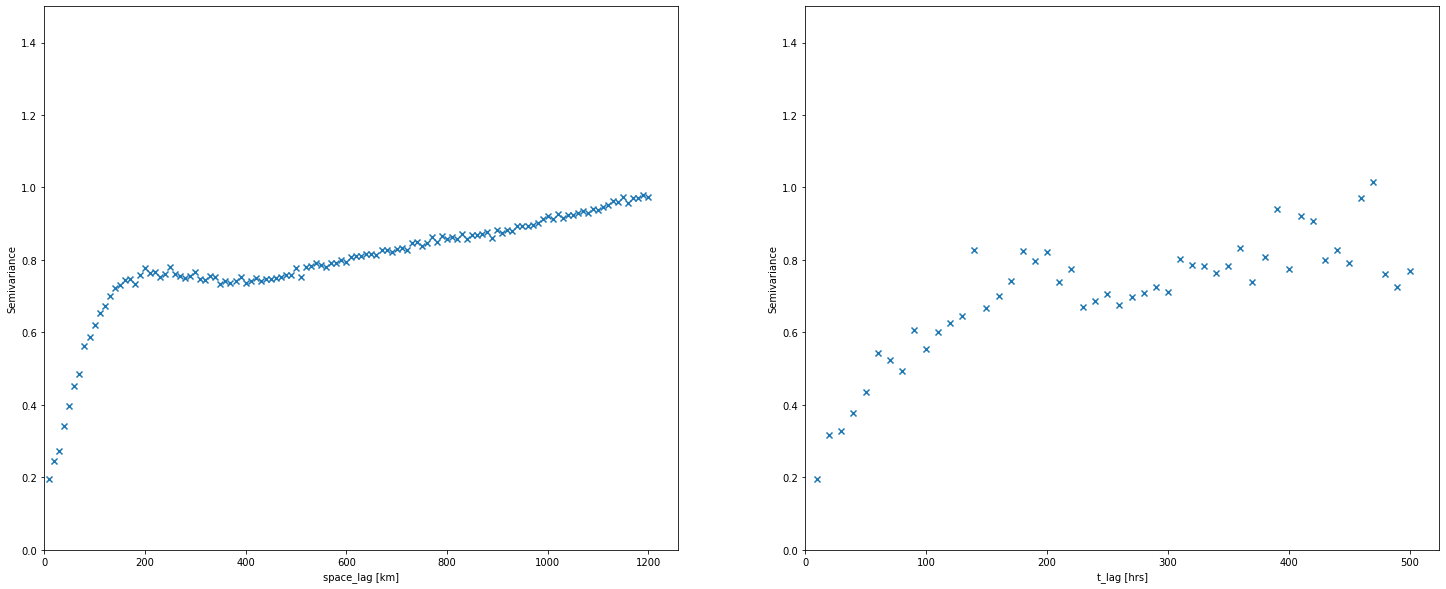

In [14]:
vvis.plot_variograms(error_variable="v", view_range=view_range)

# Compute Rank Histogram

In [11]:
import ensverif as e

# convert repeated GAN predictions to nc
predictions_dir = "../../../data/drifter_data/GAN_samples_repeated/2022-11-29_20:47:47"
ground_truth_dir = "../../../data/drifter_data/GAN_repeated_test/buoy/area1"
eval = ConvertToError(predictions_dir, ground_truth_dir)
error_root = "../../../data/drifter_data/GAN_samples_repeated/errors"
eval.get_individual_as_nc(error_root, type="error", duplicate=True)

File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!
File: GAN_pred_lon_-146.25,-125.0_lat_15.0,36.25_time_2022-09-21T12:30:00,2022-09-29T11:30:00 already exists!


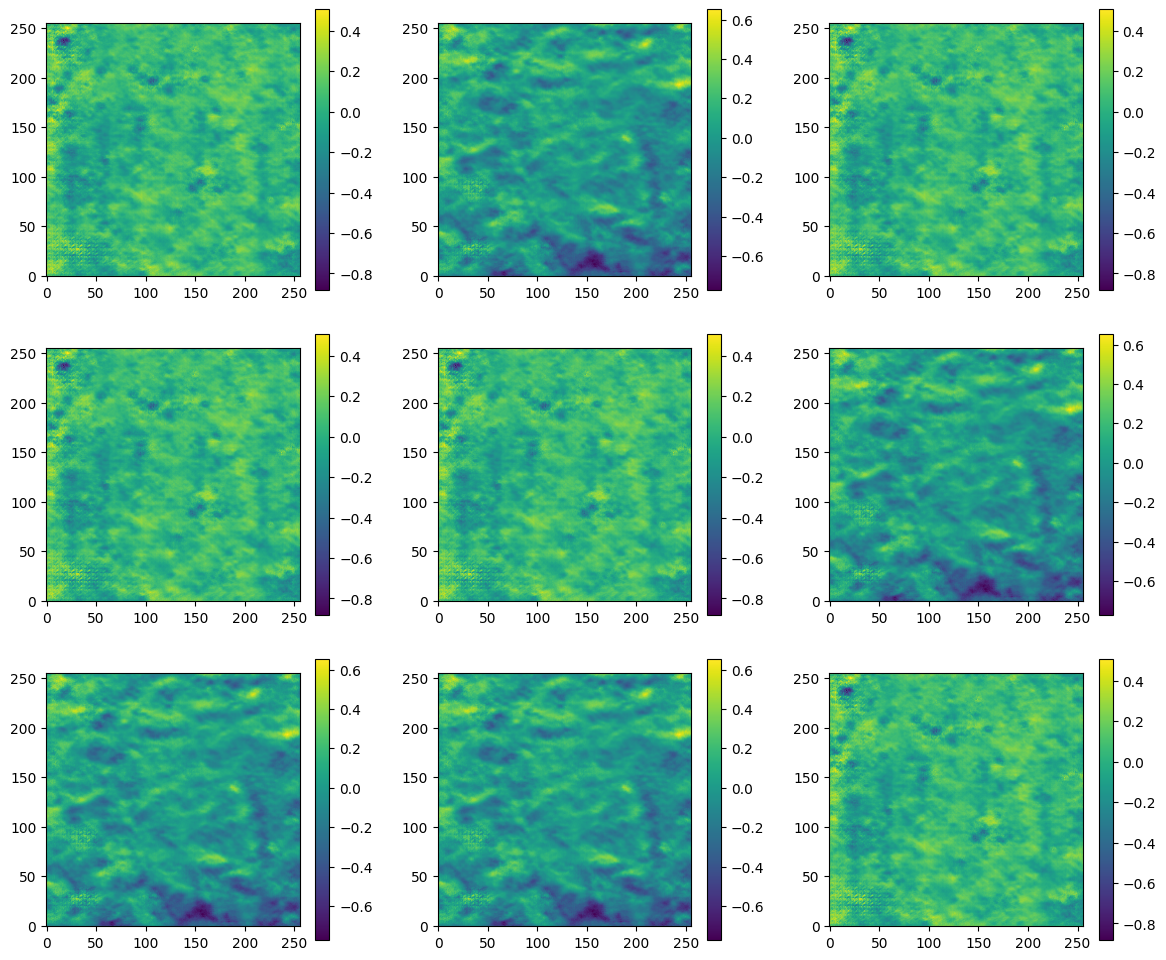

In [12]:
# load GAN predictions
error_root = "../../../data/drifter_data/GAN_samples_repeated/errors"
files = os.listdir(error_root)

current_comp = "water_u"
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for idx, file in enumerate(files[:-1]):
    axis = axs[idx%3, idx//3]
    data = xr.open_dataset(os.path.join(error_root, file), engine="netcdf4")
    frame = axis.imshow(data[current_comp].values[0], origin="lower")
    plt.colorbar(frame, ax=axis)
plt.tight_layout(pad=1.8)
plt.show()

In [33]:
# load GAN ground truth -> produced using data_preprocessing and func 'save_sparse_as_npy' with type='error'
gt_root = "../../../data/drifter_data/GAN_samples_repeated/gt_errors"
gt_file = sorted(os.listdir(gt_root))[0]
gt = np.load(os.path.join(gt_root, gt_file), allow_pickle=True)[:192]
print(gt.shape, gt_file)

(192, 2, 256, 256) copernicus_forecast_error_lon_[-14625, -125]_lat_[15, 3625]_time_2022-09-21T12:30:00Z__2022-09-30T23:30:00Z.npy


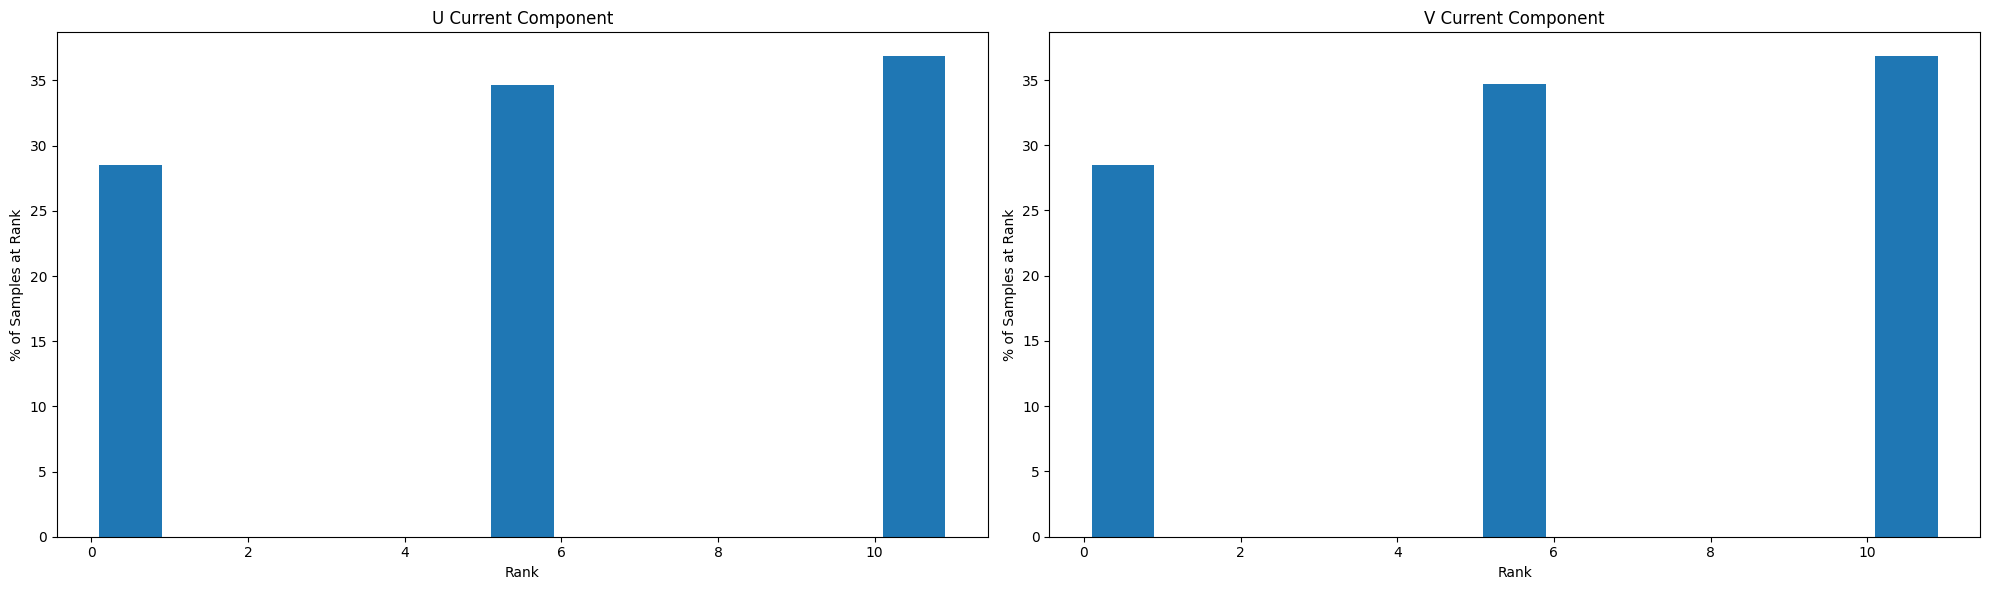

In [43]:
# GAN preds
error_root = "../../../data/drifter_data/GAN_samples_repeated/errors"
files = sorted(os.listdir(error_root))

rank_histograms = []
for i, current_comp in enumerate(["u", "v"]):
    errors = gt[:, i, :, :][np.where(gt[:, i, :, :] != 0)].flatten()
    num_ensembles = len(files)
    ensemble = np.zeros((len(errors), num_ensembles))
    for j in range(num_ensembles):
        ds = xr.load_dataset(os.path.join(error_root, files[j]))
        data = ds[f"water_{current_comp}"].values
        ensemble[:, j] = data[np.where(gt[:, i, :, :] != 0)].flatten()

    rel_freq, bins = e.rankhist(ensemble, errors)
    rank_histograms.append([rel_freq, bins])

name_dict = {0: "U", 1: "V"}
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
for i, ax in enumerate(axs):
    bins = rank_histograms[i][1]
    rel_freq = rank_histograms[i][0]
    ax.bar(bins[1:len(bins)], rel_freq*100)
    ax.set_ylabel("% of Samples at Rank")
    ax.set_xlabel("Rank")
    ax.title.set_text(f"{name_dict[i]} Current Component")
plt.tight_layout()

# Temporal Smoothness

0.03723436874868982


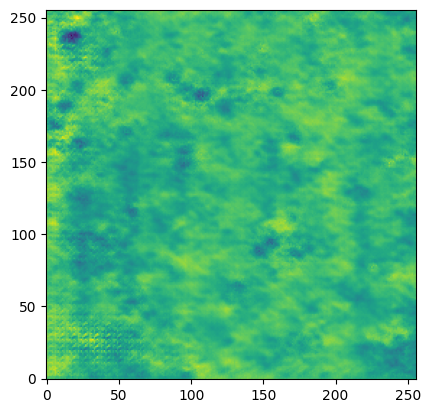

In [141]:
from ocean_navigation_simulator.generative_error_model.generative_model_metrics import temporal_smoothness

# temporal smoothness for GAN predictions
error_root = "../../../data/drifter_data/GAN_samples_repeated/errors"
files = sorted(os.listdir(error_root))
ds = xr.open_dataset(os.path.join(error_root, files[5]))
data = ds["water_u"].values

print(temporal_smoothness(data))

plt.imshow(data[0], origin="lower")

In [128]:
# temporal smoothness for forecast
fc_root = "../../../data/drifter_data/forecasts/area1"
files = sorted(os.listdir(fc_root))
print(files[139])
ds = xr.open_dataset(os.path.join(fc_root, files[139]))
data = ds["utotal"].values

print(temporal_smoothness(data))

cmems_mod_glo_phy_anfc_merged-uv_PT1H-i-2022-09-21T12:30:00Z-2022-09-21T12:30:00Z-2022-09-30T23:30:00Z.nc
(301, 661)
0.008675354811859947


In [129]:
# temporal smoothness for simplex noise
data = xr.open_dataset("../../../data/drifter_data/test_noise.nc")
data = data["water_u"].values

print(temporal_smoothness(data))

(121, 241)
0.009320174500594993


# Magnitude Distribution